In [1]:
from model import Denoising_UNet
from utils import *
from data import mask_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
import torch.nn as nn

sampleRate = 68.27

In [2]:
# Copy these parameters from the main script so that the loaded model has the same hidden layers.
N_sub = 32
batch_size = 56
hidden_layers = 4
learning_rate = 1e-6
num_epochs = 20

## Load Test Data

In [3]:
test_path = "test"
test_files = glob(os.path.join(test_path, '*.npy'))
test_dataset = mask_dataset(data_path='test', f_min=1, f_max=10, N_sub=N_sub, sampleRate=sampleRate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

In [4]:
criterion = nn.MSELoss()

## Load Trained Model

In [5]:
model = Denoising_UNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
state = torch.load('./new_model_tests/new-model-20-smallLR.pth')
model.load_state_dict(state['model_state_dict'])
model.eval();


## Get Reconstructions

In [6]:
losses = []
evals = []
outputs = []
for i, (eval_samples, masks) in tqdm(enumerate(test_loader)):
    samples = eval_samples .clone().detach()
    samples = torch.unsqueeze(samples.squeeze(), 1)
    output = model(samples)
    loss = criterion(eval_samples.squeeze(), output.squeeze()).item()
    print(f"Loss is: {loss}")
    losses.append(loss)
    evals.append(eval_samples.squeeze())
    outputs.append(output.detach().squeeze())

1it [00:00,  1.06it/s]

Loss is: 0.6671385169029236


2it [00:02,  1.02s/it]

Loss is: 0.7150242924690247


3it [00:03,  1.06s/it]

Loss is: 0.824539065361023


4it [00:04,  1.06s/it]

Loss is: 0.6615912318229675


5it [00:05,  1.09s/it]

Loss is: 0.514716625213623


6it [00:06,  1.07s/it]

Loss is: 0.6453034281730652


7it [00:07,  1.10s/it]

Loss is: 0.522864043712616


8it [00:08,  1.09s/it]

Loss is: 0.39037415385246277


9it [00:09,  1.09s/it]

Loss is: 0.39926978945732117


10it [00:10,  1.10s/it]

Loss is: 0.3697434067726135


11it [00:11,  1.11s/it]

Loss is: 0.5049278140068054


12it [00:12,  1.10s/it]

Loss is: 0.67354816198349


13it [00:14,  1.09s/it]

Loss is: 1.0556777715682983


14it [00:15,  1.09s/it]

Loss is: 2.23895525932312


15it [00:16,  1.09s/it]

Loss is: 1.2494465112686157


16it [00:17,  1.12s/it]

Loss is: 0.7882667183876038


17it [00:18,  1.12s/it]

Loss is: 0.6585782766342163


18it [00:19,  1.11s/it]

Loss is: 0.4998724162578583


19it [00:20,  1.10s/it]

Loss is: 0.3616277873516083


20it [00:21,  1.08s/it]

Loss is: 0.25072064995765686


21it [00:22,  1.07s/it]

Loss is: 0.16058850288391113


22it [00:23,  1.06s/it]

Loss is: 0.34270724654197693


23it [00:24,  1.06s/it]

Loss is: 0.4472620487213135


24it [00:25,  1.06s/it]

Loss is: 0.7740656733512878


25it [00:27,  1.06s/it]

Loss is: 0.9255291223526001


26it [00:28,  1.06s/it]

Loss is: 0.5343812704086304


27it [00:29,  1.09s/it]

Loss is: 0.7128363847732544


28it [00:30,  1.10s/it]

Loss is: 0.3940337300300598


29it [00:31,  1.12s/it]

Loss is: 0.6543866395950317


30it [00:32,  1.10s/it]

Loss is: 0.6614245176315308


31it [00:33,  1.10s/it]

Loss is: 0.5400634407997131


32it [00:34,  1.10s/it]

Loss is: 0.4898441433906555


33it [00:35,  1.09s/it]

Loss is: 0.3303728699684143


34it [00:36,  1.09s/it]

Loss is: 0.26637002825737


35it [00:37,  1.08s/it]

Loss is: 0.5491830706596375


36it [00:39,  1.06s/it]

Loss is: 0.43406224250793457


37it [00:40,  1.05s/it]

Loss is: 0.543334424495697


38it [00:41,  1.05s/it]

Loss is: 0.7509291768074036


39it [00:42,  1.06s/it]

Loss is: 0.5358585119247437


40it [00:43,  1.07s/it]

Loss is: 0.7470482587814331


41it [00:44,  1.07s/it]

Loss is: 0.7626561522483826


42it [00:45,  1.08s/it]

Loss is: 0.6397235989570618


In [27]:
min_loss = np.argmin(losses)
outputs_ = [taper_filter(i, 1, 10, sampleRate) for i in outputs]

In [28]:
batch_idx = min_loss  # select batch with min loss
event = 10  # select one of 56 events
channel = 16  #if you want to do a line plot, pick channel

I chose channel 16 as it is the one that's more frequently targeted and blanked out (it's the center one),  
 so that's the most interesting channel to pick to see how the reconstruction is done.

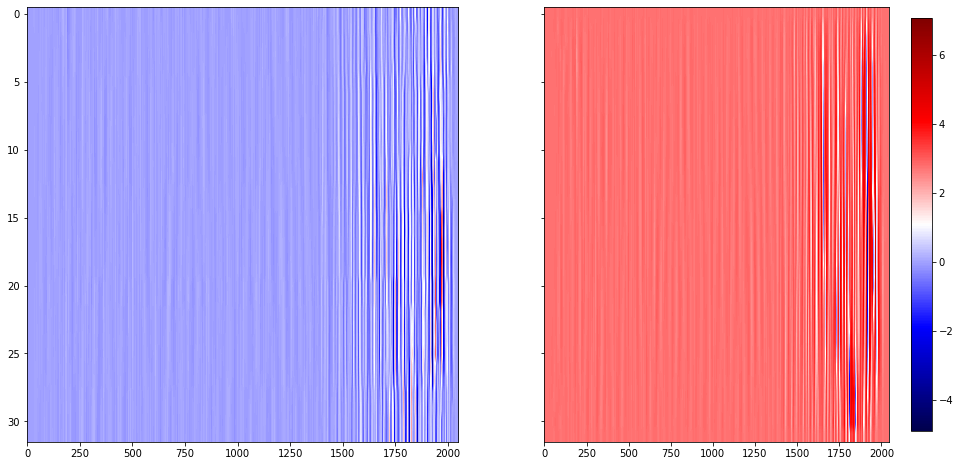

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8), sharex=True, sharey=True)
pl1 = ax1.imshow(evals[batch_idx][event], aspect='auto', cmap='seismic')
pl2 = ax2.imshow(outputs_[batch_idx][event], aspect='auto', cmap='seismic')
cbar = fig.colorbar(pl1, ax=ax2, shrink=0.95)

## Wiggle for wiggle comparison on center channel

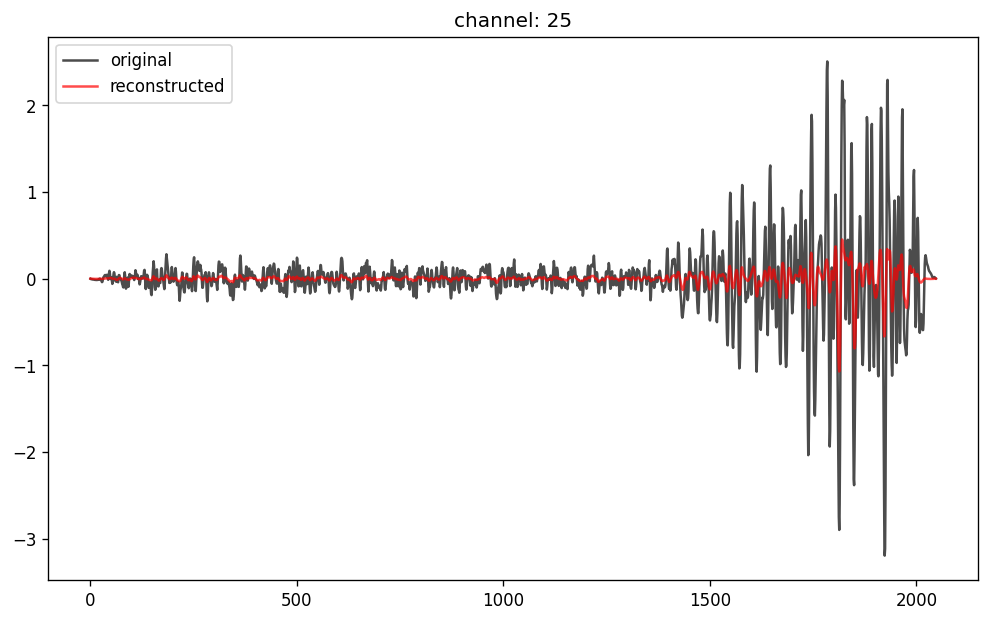

In [35]:
plt.figure(figsize=(10, 6), dpi=120)
plt.plot(evals[batch_idx][event + 2, channel], alpha=0.7, label='original', color='black')
plt.plot(outputs_[batch_idx][event + 2, channel], alpha=0.7, label='reconstructed', color='red')
plt.title(f"channel: {channel}")
plt.legend()

## Wiggle for wiggle comparison on other channels

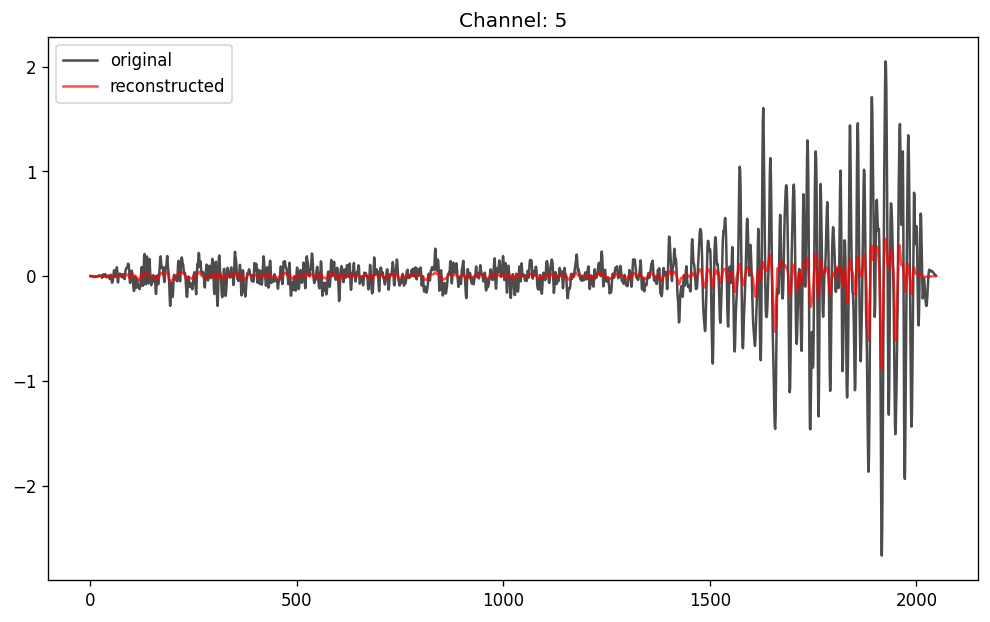

In [31]:
plt.figure(figsize=(10, 6), dpi=120)
channel = 5
plt.plot(evals[batch_idx][event, channel], alpha=0.7, label='original', color='black')
plt.plot(outputs_[batch_idx][event, channel], alpha=0.7, label='reconstructed', color='red')
plt.title(f"Channel: {channel}")
plt.legend()

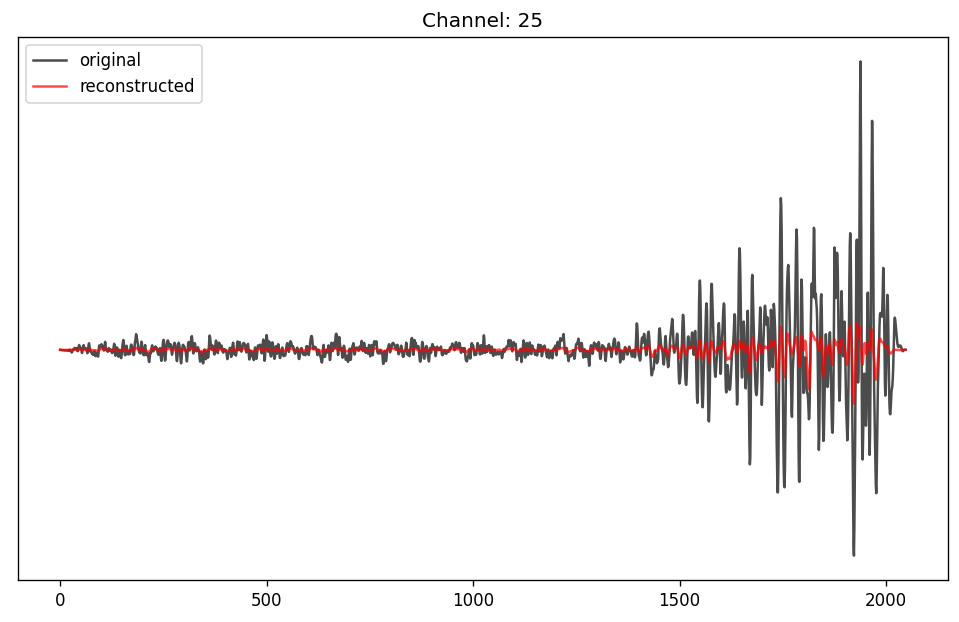

In [32]:
plt.figure(figsize=(10, 6), dpi=120)
channel = 25
plt.plot(evals[batch_idx][event, channel], alpha=0.7, label='original', color='black')
plt.plot(outputs_[batch_idx][event, channel], alpha=0.7, label='reconstructed', color='red')
plt.title(f"Channel: {channel}")
plt.yticks([])
plt.legend()

In [33]:
# plt.plot(compute_moving_coherence(outputs_[batch_idx][event,channel],16))
# plt.axhline(y=1)

This screenshot is from the original paper, so we're close but we have a long way to go.

![Reference](./reference.png)